# Task 1: Exploratory analysis and hypothesis driven bioinformatic workflow implementation: First Analysis
# Differentially expressed genes and pathway enrichment to compare healthy and cancer samples

---

## Objectives

- Identify differentially expressed genes (DEGs) between defined clinical or biological groups using **PyDESeq2**.
- Explore biological processes and pathways enriched among DEGs using **Gene Set Enrichment Analysis (GSEA)** via **GSEApy**.
- Visualize expression patterns and enrichment results using advanced plotting techniques.

---

## Tools and Methods

- **PyDESeq2**: A Python implementation of the DESeq2 statistical framework for RNA-seq count data. It models gene expression using a negative binomial distribution and accounts for biological variability.
- **GSEApy**: A Python wrapper for gene set enrichment analysis, supporting pre-ranked GSEA and many public gene set libraries (e.g., GO, KEGG, Reactome).
- **Seaborn / Matplotlib**: For customized heatmaps, volcano plots, and enrichment plots.

---

## Workflow Overview

1. **Data Preparation**
   - Load raw count (the main data used in pydeseq), normalized and filtered count data (TMM+log normalization) for visualization, and metadata .
   - Match samples between expression and metadata tables.
   - Optional scaling for exploratory visualizations.

2. **Differential Expression Analysis**
   - Use PyDESeq2 to model differential expression between groups.
   - Extract and visualize top significant genes.

3. **Gene Set Enrichment**
   - Rank genes based on test statistic (e.g., Wald stat or log2 fold change).
   - Run GSEA on ranked gene list using GSEApy (GO terms).
   - Plot top enriched biological pathways or GO terms.

---

## Input Data

- **Expression matrix**: Batch-corrected and normalized gene expression data.
- **Metadata**: Clinical/phenotypic data including sample type, age, sex, etc.



#### Note: This analysis is automated in the `scripts` folder with configurable parameters. The pipeline is used in Notebook3. 



### 1.Differential Expression Analysis (DE) with PyDESeq2

I apply the DESeq2 framework via PyDESeq2 to identify differentially expressed genes (DEGs) between predefined groups (e.g., tumor vs normal). PyDESeq2 fits a negative binomial model and adjusts for dispersion and covariates (I used age, sex, biopsy site) when provided. Significant genes are visualized via volcano plots and heatmaps.



In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
import warnings
warnings.filterwarnings("ignore")

# importing the datasets and subsetting with filtered metadata
metadata_df = pd.read_csv('../data/metadata_nonan.csv', index_col=0)
count_df = pd.read_csv('../data/raw_expression.csv', index_col=0).loc[metadata_df.index]
count_df = count_df.loc[:, count_df.sum(axis=0) > 0]
scaled_log_tmm = pd.read_csv('../data/scaled_log_expression.csv', index_col=0).loc[metadata_df.index]

In [3]:
# Create DESeqDataSet object
dds = DeseqDataSet(
    counts=count_df,  
    metadata=metadata_df,
    design_factors=["sample_type", 'age','gender','biopsy_site'],
    refit_cooks=True,
)

# Run DESeq2 pipeline
dds.deseq2()



Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 4.05 seconds.

Fitting dispersions...
... done in 43.62 seconds.

Fitting dispersion trend curve...
... done in 2.21 seconds.

Fitting MAP dispersions...
... done in 34.18 seconds.

Fitting LFCs...
... done in 28.92 seconds.

Calculating cook's distance...
... done in 10.52 seconds.

Replacing 873 outlier genes.

Fitting dispersions...
... done in 2.01 seconds.

Fitting MAP dispersions...
... done in 1.97 seconds.

Fitting LFCs...
... done in 2.30 seconds.



In [4]:
# # Perform differential expression statistics (e.g., Tumor vs Normal)
ds = DeseqStats(dds, n_cpus=1,  contrast = ('sample_type','Primary cancer','Healthy sample'))
ds.summary()

# Results DataFrame
results = ds.results_df

results = results[results.baseMean >= 10]

# Rank genes by log2 fold change
results = results.dropna(subset=["log2FoldChange", "pvalue"])

# Example ranking: by Wald statistic (stat column)
ranked_genes = results.sort_values(by="stat", ascending=False)

# Prepare ranked list for GSEA: gene names as index, stat as values
ranked_gene_list = pd.Series(data=ranked_genes["stat"].values, index=ranked_genes.index)

# Save ranked_gene_list to gseapy
ranked_gene_list.to_csv("../results/ranked_genes.csv", header=False)


Running Wald tests...
... done in 28.27 seconds.



Log2 fold change & Wald test p-value: sample_type Primary cancer vs Healthy sample
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG         58.851374       -1.976967  0.117345 -16.847420   1.095921e-63   
A1BG-AS1     28.601193       -1.270155  0.064285 -19.758038   6.841313e-87   
A1CF        717.089125        0.888308  0.132941   6.681961   2.357660e-11   
A2M       15132.752827       -0.188690  0.054892  -3.437507   5.870952e-04   
A2M-AS1     217.912594       -0.155180  0.109331  -1.419358   1.557945e-01   
...                ...             ...       ...        ...            ...   
ZYG11A        5.555090        0.330706  0.098285   3.364765   7.660895e-04   
ZYG11B     1517.213739       -1.011148  0.035227 -28.703914  3.409342e-181   
ZYX        5849.760560        1.502991  0.044040  34.128066  2.829214e-255   
ZZEF1      4088.245975       -1.203938  0.039303 -30.631966  4.595023e-206   
ZZZ3       1386.399023       -0.109500  0.026049  -4.203673

### Differential Expression Analysis: Colorectal Cancer vs. Healthy Samples Results

#### Volcano Plot (Top)

- **X-axis:** Log2 Fold Change (log2FC) — reflects magnitude and direction of gene expression changes between colorectal cancer and healthy tissue  
- **Y-axis:** -log10 Adjusted p-value — indicates statistical significance of differential expression  
- **Colors:** Red = genes significantly differentially expressed (padj < 0.05), Grey = not significant  

**Key points:**  
- The characteristic "volcano" shape shows a dense cluster of genes with little or no change (near zero log2FC) and "wings" representing genes strongly up- or down-regulated in colorectal cancer compared to healthy tissue.  
- Balanced numbers of significantly upregulated and downregulated genes suggest a complex molecular alteration landscape in colorectal cancer.  
- Extremely low adjusted p-values for some genes highlight highly confident candidates potentially involved in cancer pathogenesis.  
- Overall, the plot confirms robust differential expression consistent with expected biological differences between cancer and normal tissue.

---

#### MA Plot (Bottom)

- **X-axis:** Mean normalized counts — average expression level of each gene across all samples  
- **Y-axis:** Log2 Fold Change (log2FC) — degree of differential expression between colorectal cancer and healthy samples  
- **Colors:** Red = significant genes, Grey = non-significant  

**Key points:**  
- Most genes show minimal change (log2FC near zero), especially those with low expression levels, consistent with expected noise.  
- Significant genes (red dots) are distributed symmetrically above and below zero, indicating both up- and down-regulation in colorectal cancer.  
- Increased variability in fold change among higher expressed genes reflects biological heterogeneity and measurement accuracy.  
- The plot exhibits no abnormal trends or biases, supporting the reliability of the analysis.

---

#### Summary

- Both plots demonstrate a clear and biologically plausible differential gene expression pattern between colorectal cancer and healthy tissues.  
- The presence of many significant genes with substantial fold changes reflects key molecular alterations underlying colorectal tumorigenesis.  
- The analysis results are consistent with well-behaved data, suitable for downstream functional interpretation and pathway analysis.


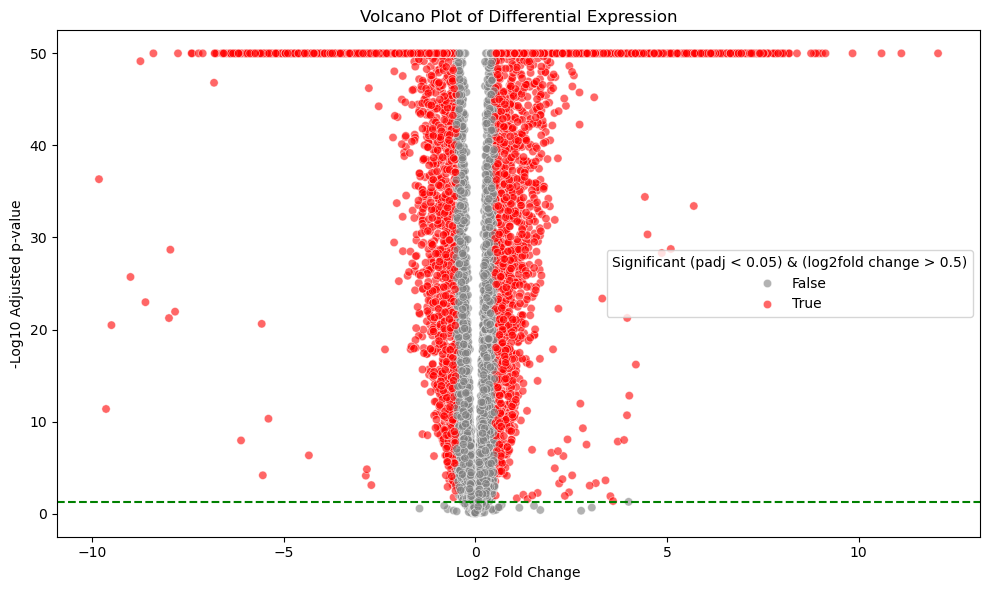

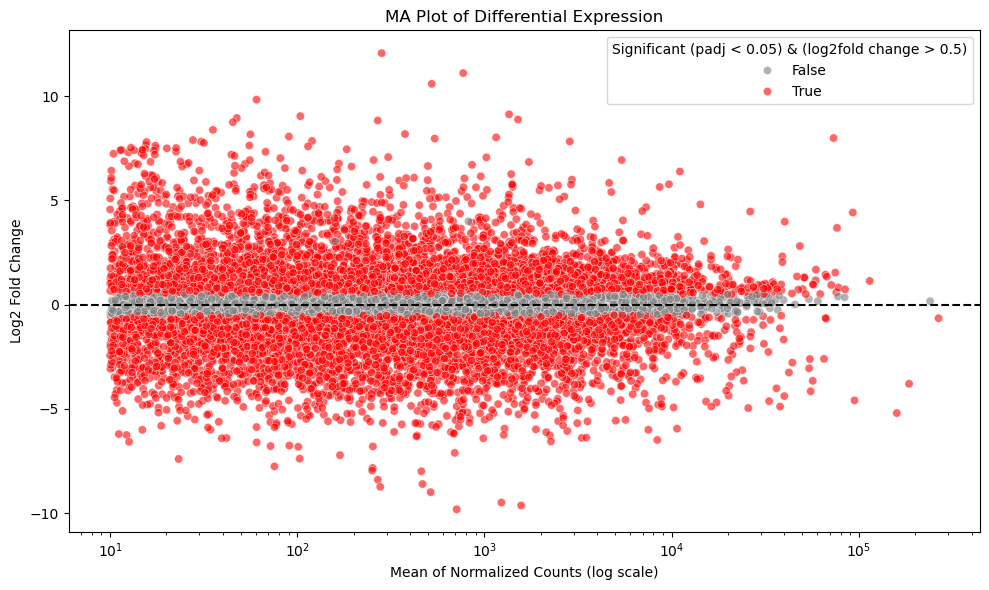

In [15]:

# Filter out genes with missing values
results = results.dropna(subset=["log2FoldChange", "padj"])

# Replace padj = 0 with smallest positive value
results['padj'] = results['padj'].replace(0,  1e-323)

# log2FoldChange vs -log10(padj)
results['neg_log10_padj'] = -np.log10(results['padj'])
results['neg_log10_padj'] = results['neg_log10_padj'].clip(upper=50)
# Volcano Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='log2FoldChange', y='neg_log10_padj',
                hue=(results.padj < 0.05) & (abs(results.log2FoldChange) > 0.5), palette={True: 'red', False: 'grey'}, alpha=0.6)
# Add reference lines
plt.axhline(y=-np.log10(0.05), color='green', linestyle='--')
plt.title('Volcano Plot of Differential Expression')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 Adjusted p-value')
plt.legend(title='Significant (padj < 0.05) & (log2fold change > 0.5)')
plt.tight_layout()
plt.savefig('../results/volcano_plot.png')  
plt.show()

# MA Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=results, x='baseMean', y='log2FoldChange',
                hue=(results.padj < 0.05) & (abs(results.log2FoldChange) > 0.5), palette={True: 'red', False: 'grey'}, alpha=0.6)
plt.xscale('log')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('MA Plot of Differential Expression')
plt.xlabel('Mean of Normalized Counts (log scale)')
plt.ylabel('Log2 Fold Change')
plt.legend(title='Significant (padj < 0.05) & (log2fold change > 0.5)')
plt.tight_layout()
plt.savefig('../results/MA_plot.png')  
plt.show()



#### Clustered Heatmap of Top Genes

**Key points:**  
- The clustered heatmap of the 20 most significant differentially expressed genes reveals distinct and alternating expression patterns between healthy and colorectal cancer samples.  
- This clear separation supports the robustness of the differential expression results and highlights potential biomarkers or drivers of tumorigenesis.


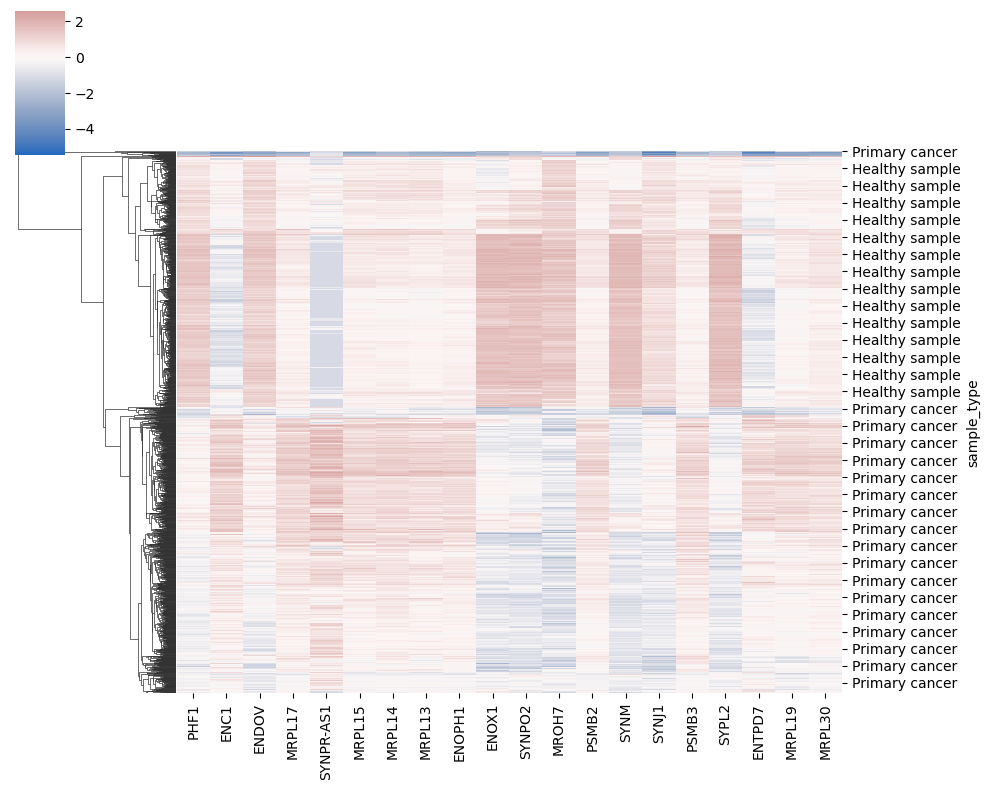

In [14]:
# Sort genes
filtered_results = results[results['log2FoldChange'].abs() >= 1]
top_genes = filtered_results.sort_values("padj").head(20).index

# Get heatmap data
heatmap_data = scaled_log_tmm[top_genes] 

# Replace sample names (index) with class labels
heatmap_data.index = metadata_df.loc[heatmap_data.index, 'sample_type']  

#clustered heatmap
g = sns.clustermap(heatmap_data, cmap="vlag", figsize=(10, 8), col_cluster=False, center=0)
g.savefig('../results/clustered_heatmap.png', dpi=300)
plt.show()


##  Gene Set Enrichment Analysis (GSEA) with GSEApy

Since there are many differentially expressed genes, I will do GSEA to understand results better. Using the ranked list of genes, I perform pre-ranked Gene Set Enrichment Analysis (GSEA) with GSEApy. This helps identify enriched biological pathways or GO terms associated with the observed gene expression patterns. Top pathways are visualized with enrichment plots.

### Results
- **DNA-dependent DNA replication (GO:0006261)**  
  Strong enrichment indicates elevated DNA replication activity, consistent with the high proliferative rate of CRC cells.  
  Leading edge genes include *RFC3, PSMD14, MCM4, GINS4, RPA3*, among others, which are essential for DNA synthesis and replication fork progression.

- **rRNA processing (GO:0006364)**  
  Increased rRNA processing suggests upregulated ribosome assembly and protein synthesis machinery in tumor cells.  
  Key genes: *DKC1, DDX47, NOB1, DCAF13, WDR43*.

- **Ribosome biogenesis (GO:0042254)**  
  Upregulation of ribosome biogenesis pathways supports rapid growth and translation in CRC.  
  Leading genes include *DKC1, DDX47, NIP7, NOB1, DCAF13*.

- **rRNA metabolic process (GO:0016072)**  
  Active metabolism of rRNA reflects high ribosomal turnover, characteristic of cancer cell metabolism.  
  Important genes: *DKC1, DDX47, NOB1, DCAF13, WDR43*.

- **Pre-replicative complex assembly (GO:0036388)**  
  This pathway’s enrichment highlights early events in DNA replication initiation, critical for cell cycle progression.  
  Leading genes include *PSMD14, MCM4, PSMB2, MCM3, ORC6*.

---

### Biological Context

- **DNA replication and pre-replicative complex pathways** are strongly enriched, confirming the heightened proliferative state in CRC tumors.  
- **Ribosome biogenesis and rRNA processing/metabolism** pathways show increased activity, supporting enhanced protein synthesis required for rapid tumor growth.  
- The identified leading edge genes represent crucial players in these processes and could serve as potential biomarkers or therapeutic targets in colorectal cancer.

---



In [ ]:
# Load ranked genes
ranked_genes = pd.read_csv("../results/ranked_genes.csv", index_col=0)

# Run pre-ranked GSEA using GO pathways
pre_res = gp.prerank(
    rnk=ranked_genes,
    gene_sets='GO_Biological_Process_2021',
    permutation_num=100,  
    outdir='../results/gsea_results',  
    no_plot=False,
    seed=42
)

# # Print top 5 enriched gene sets
print(pre_res.res2d.head())



2025-08-11 15:07:39,543 [WARNING] Duplicated values found in preranked stats: 0.10% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


      Name                                           Term        ES       NES  \
0  prerank     DNA-dependent DNA replication (GO:0006261)  0.656821  2.915443   
1  prerank                   rRNA processing (GO:0006364)  0.632622  2.811995   
2  prerank               ribosome biogenesis (GO:0042254)  0.612025  2.738833   
3  prerank            rRNA metabolic process (GO:0016072)  0.614543  2.719642   
4  prerank  pre-replicative complex assembly (GO:0036388)  0.674523  2.667338   

  NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0       0.0       0.0        0.0   81/128  21.72%   
1       0.0       0.0        0.0  126/167  26.84%   
2       0.0       0.0        0.0  129/184  23.88%   
3       0.0       0.0        0.0  115/154  26.84%   
4       0.0       0.0        0.0    41/64  20.25%   

                                          Lead_genes  
0  RFC3;PSMD14;MCM4;GINS4;RPA3;GINS1;HMGA1;PSMB2;...  
1  DKC1;DDX47;NOB1;DCAF13;WDR43;WDR12;EXOSC5;WDR3...  
2  DKC1;DDX47;NIP7;NOB1;DCAF1

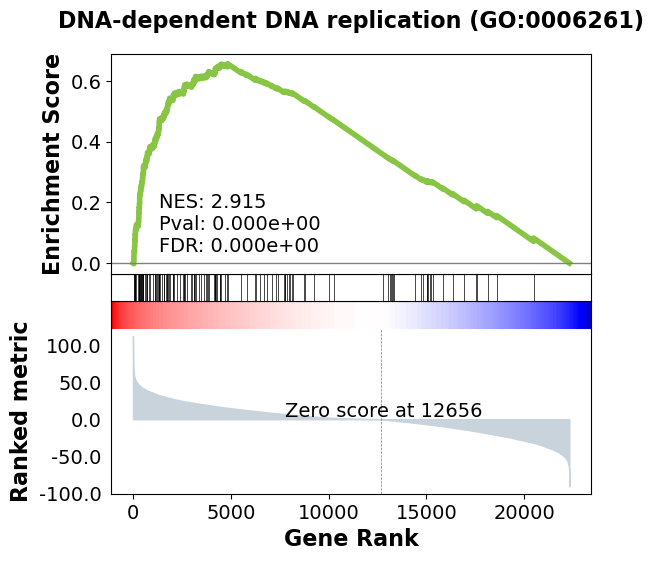

In [ ]:
# Get top enriched term name (as string)
top_term = pre_res.res2d['Term'][0]

# Access full result for that term
gsea_result = pre_res.results[top_term]

# Plot using gseaplot() — requires hits and res
gp.plot.gseaplot(
    hits=gsea_result['hits'],
    RES=gsea_result['RES'],
    term=top_term,
    rank_metric=pre_res.ranking,
    nes=gsea_result['nes'],
    pval=gsea_result['pval'],
    fdr=gsea_result['fdr']
)

plt.show()


# Genes with Established Biomarker Potential in CRC

## RFC3 (Replication Factor C Subunit 3)
- Elevated expression of RFC3 has been observed in CRC tissues and cells.
- Depletion of RFC3 halted CRC cell proliferation, migration, invasion, and angiogenesis, indicating its potential as a therapeutic target and biomarker for CRC progression.
- **Reference:** [Yu et al., 2024, PMC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC11000453/)

## PSMD14 (Proteasome 26S Subunit, Non-ATPase 14)
- Identified as a novel prognostic marker in CRC.
- Knocking down PSMD14 expression reduced tumor cell proliferation and drug resistance, suggesting its role in CRC progression and therapy resistance.
- **Reference:** [Seo et al., 2019, PMC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7113187/)

## MCM4 (Minichromosome Maintenance Complex Component 4)
- Closely associated with oncogenesis, prognosis, and diagnosis in various cancers, including CRC.
- Overexpression linked to poor prognosis, making it a potential biomarker for CRC.
- **Reference:** [Li et al., 2024, Nature](https://www.nature.com/articles/s41598-024-57299-1)

## GINS4 (GINS Complex Subunit 4)
- Overexpression observed in CRC tissues and cells.
- Serves as a significant prognostic biomarker and promotes CRC growth by inhibiting cell apoptosis.
- **References:** [Rong et al., 2020, PMC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7156840/), [Zhang et al., 2021, PubMed](https://pubmed.ncbi.nlm.nih.gov/32012389/)

## DKC1 (Dyskeratosis Congenita 1)
- Implicated in CRC progression and therapy resistance.
- Promotes CRC progression by dysregulating sphingolipid biosynthesis, suggesting potential as a biomarker.
- **Reference:** [Hou et al., *Br J Cancer*, 2020, 122:668–679](https://www.nature.com/articles/s41416-019-0695-z)

## NOB1 (Nucleolar Biogenesis Protein 1)
- Overexpressed in many cancers, including CRC, and mediates different stages of tumor development.
- Attractive target in anticancer therapy, indicating potential as a biomarker for CRC.
- **References:** [Ke et al., *Curr Drug Targets*C](https://pubmed.ncbi.nlm.nih.gov/30854959/)
